In [4]:
# Import Statements
import torch.nn as nn
from torchvision import models
from tqdm import tqdm
from PIL import Image
import umap
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Device
# GPU useage test
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [6]:
# Model
class ResNet101Intermediate(nn.Module):
    def __init__(self):
        super().__init__()

        # Load pretrained ResNet101
        base = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V1)

        # Extract layers
        self.conv1 = base.conv1
        self.bn1 = base.bn1
        self.relu = base.relu
        self.maxpool = base.maxpool

        self.layer1 = base.layer1
        self.layer2 = base.layer2
        self.layer3 = base.layer3
        self.layer4 = base.layer4
        
        # Pools for genus and species embeddings
        self.layer3_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.avgpool = base.avgpool  # for species level

        # Freeze weights
        for p in self.parameters():
            p.requires_grad = False

        self.eval()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        # Genus embedding (intermediate semantic level)
        g = self.layer3_pool(x).flatten(1)

        x = self.layer4(x)

        # Species embedding (more fine-grained)
        s = self.avgpool(x).flatten(1)

        return g, s

In [7]:
# Instantiate the model
model = ResNet101Intermediate().to(device).eval()

In [8]:
# Extract embeddings
genus_embeds, species_embeds, hash_order = [], [], []

with torch.no_grad():
    for hids, imgs in tqdm(loader, desc="Extracting embeddings"):
        imgs = imgs.to(device, non_blocking=True)
        
        g, s = model(imgs)

        # Move embeddings to cpu for storage
        genus_embeds.append(g.cpu().numpy())
        species_embeds.append(s.cpu().numpy())
        hash_order.extend(hids)

genus_embeds = np.vstack(genus_embeds)
species_embeds = np.vstack(species_embeds)

print("Genus embeddings shape:", genus_embeds.shape)
print("Species embeddings shape:", species_embeds.shape)

Extracting embeddings: 100%|██████████| 776/776 [13:01<00:00,  1.01s/it]


Genus embeddings shape: (49633, 1024)
Species embeddings shape: (49633, 2048)


C:\Users\mlasz\anaconda3\envs\biotrove\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


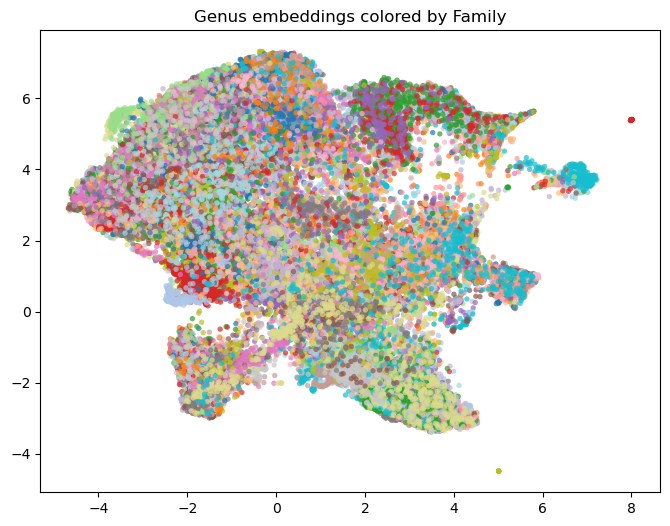

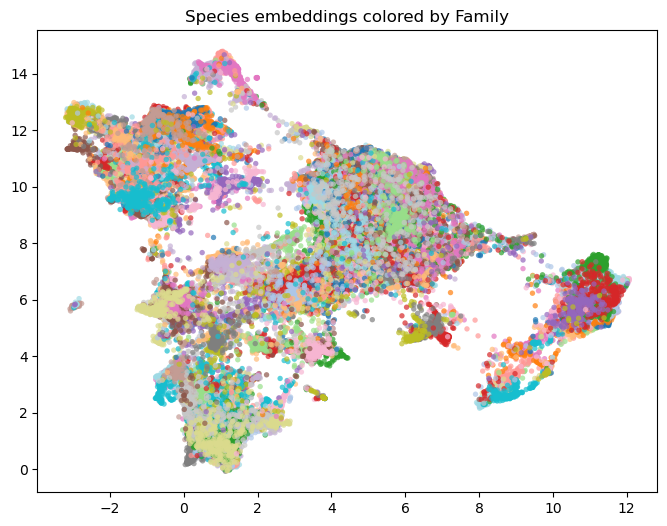

In [10]:
# Reduce to 2D for plotting
umap_2d = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.1, random_state=seed)
genus_2d = umap_2d.fit_transform(genus_embeds)
species_2d = umap_2d.fit_transform(species_embeds)

# Plot function
def plot_umap(coords, labels, title):
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=coords[:,0], y=coords[:,1], hue=labels, s=15, linewidth=0, alpha=0.7, palette="tab20")
    plt.title(title)
    plt.legend([],[], frameon=False)
    plt.show()

# Visualize embeddings colored by family
plot_umap(genus_2d, df_meta['family'], "Genus embeddings colored by Family")
plot_umap(species_2d, df_meta['family'], "Species embeddings colored by Family")